In [2]:
%matplotlib notebook

In [3]:
import sys
sys.path.append("../../")

from dmp.data.logging import _get_sql_engine
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
from joblib import Memory
from ipywidgets import interact, interact_manual

import scipy.interpolate

import plotly.graph_objects as go

import matplotlib.pyplot as plt

In [4]:
db = _get_sql_engine()

memory = Memory(location="./cache", verbose=0)

def query(query_string):
    with db.connect() as engine:
        return pd.read_sql(query_string, engine)

cached_query = memory.cache(query)

def clear_cache():
    memory.clear()
    
options = {
    "dataset": ['529_pollen',
        'sleep',
        'adult',
        '537_houses',
        'nursery',
        '201_pol',
        'mnist',
        'connect_4',
        'wine_quality_white'],
    "agg": ["avg", "min", "max"],
    "topology" : ["exponential", "rectangle", "trapezoid", "wide_first"],
    "loss": ['history_loss', 'history_hinge', 'history_accuracy',
       'history_val_loss', 'history_val_hinge', 'history_val_accuracy',
       'history_squared_hinge', 'history_cosine_similarity',
       'history_val_squared_hinge', 'history_mean_squared_error',
       'history_mean_absolute_error', 'history_val_cosine_similarity',
       'history_val_mean_squared_error', 'history_root_mean_squared_error',
       'history_val_mean_absolute_error',
       'history_kullback_leibler_divergence',
       'history_val_root_mean_squared_error',
       'history_mean_squared_logarithmic_error',
       'history_val_kullback_leibler_divergence',
       'history_val_mean_squared_logarithmic_error'],
    "residual_mode": ["none", "full"]
}

<IPython.core.display.Javascript object>


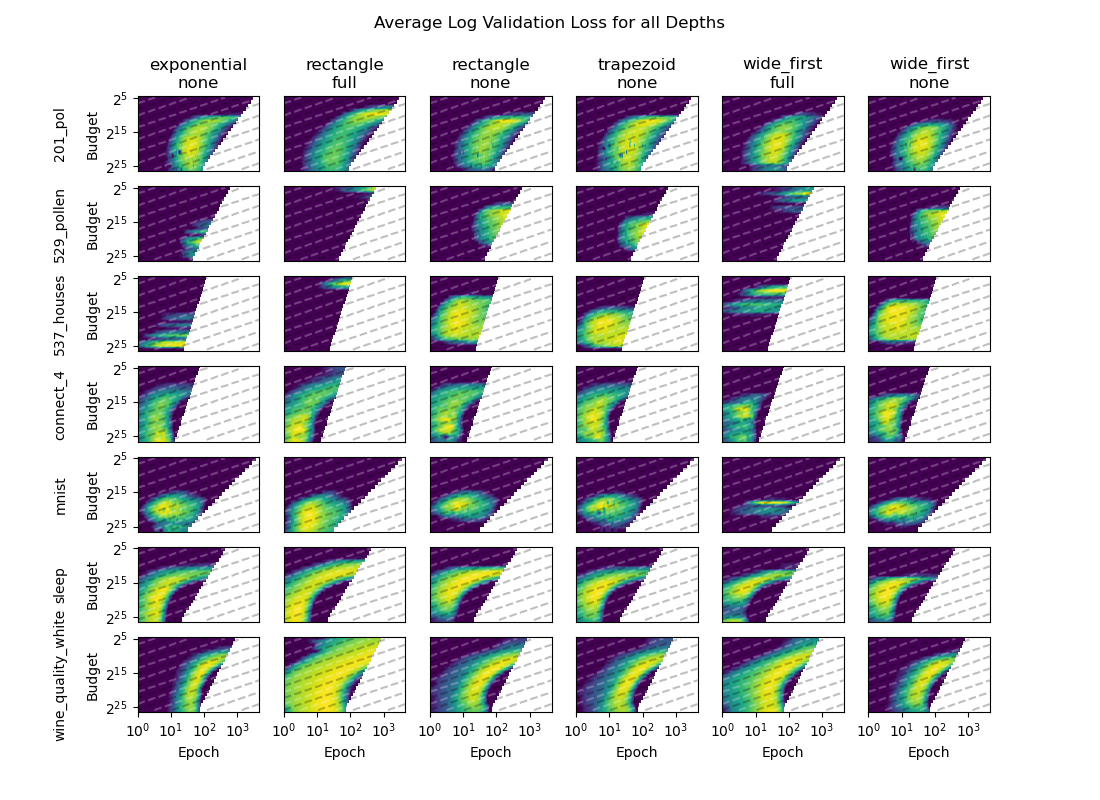

Text(0.5, 0.98, 'Average Log Validation Loss for all Depths')

In [106]:
query_string = f'''
select "config.budget", avg(a.val) as value, count(a.val), a.epoch, "config.dataset", "config.topology", "config.residual_mode"
from
    materialized_experiments_0 t,
    unnest(t.history_val_loss) WITH ORDINALITY as a(val, epoch)
WHERE
    "groupname"='fixed_01'
GROUP BY epoch, "config.budget", "config.dataset", "config.topology", "config.residual_mode"
'''
df = cached_query(query_string)

df["log_epoch"] = np.log10((df["epoch"]))

df["config.topology"] = df["config.topology"] + "\n" + df["config.residual_mode"]

df["value"] = np.log(df["value"])

x_axes = np.linspace(df["log_epoch"].min(), df["log_epoch"].max(), 500)

ROWS = 7
COLS = 6

fig, axs = plt.subplots(ROWS,COLS, figsize=(11,8), dpi=100, sharex=True)

i = 0
for idx, gdf in df.groupby(["config.dataset", "config.topology"]):
    img = np.ndarray(shape=(22,500))
    
    v_range = gdf["value"].max() - gdf["value"].min()

    for row_idx, row_df in gdf.groupby("config.budget"):
        
        color_scale = 0.2
        
        intp = scipy.interpolate.interp1d(row_df["log_epoch"],
                                          row_df["value"],
                                          kind='linear',
                                          bounds_error=False)

        row_idx = int(np.log2(row_idx)-5)
        
        vals = intp(x_axes)
        vals = np.minimum(gdf["value"].min()+(v_range*color_scale), vals)
        img[row_idx, :] = vals

        
    #value_min = df[df["config.dataset"]==idx[0]]["value"].min()
    #value_max = df[df["config.dataset"]==idx[0]]["value"].max()
    
    ax = axs[i//COLS, i%COLS]
    pcm = ax.imshow(img, aspect="auto", cmap="viridis_r")#, vmin=value_min, vmax=value_max)
    
    X,Y = np.meshgrid(np.arange(0,500),np.arange(0, 22))
    Z = np.power(10, x_axes[X])*np.power(2, Y+5)
    
    clevels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), 20)
    ax.contour(Z,  levels=clevels[1::2], colors="white", linestyles="dashed", alpha=0.25)
    ax.contour(Z,  levels=clevels[::2], colors="black", linestyles="dashed", alpha=0.25)

    if i%COLS == 0:
        ax.set_ylabel(idx[0]+"\n\nBudget")
        ticks = [0, 10, 20]
        ax.set_yticks(ticks, minor=False)
        labels = ["$2^{"+str(x+5)+"}$" for x in ticks]
        ax.set_yticklabels(labels, fontdict=None, minor=False)
    else:
        ax.yaxis.set_visible(False)

    if i//COLS != 6:
        ax.xaxis.set_visible(False)

    if i//COLS == 0:
        ax.set_title(idx[1])
        
    if i//COLS == 6:
        labels = [0,1,2,3]
        ticks = [np.abs(x_axes-i).argmin() for i in [0,1,2,3]]
        ax.set_xticks(ticks, minor=False)
        labels = ["$10^{"+str(x)+"}$" for x in labels]
        ax.set_xticklabels(labels, fontdict=None, minor=False)
        ax.set_xlabel("Epoch")

    i = i + 1

#fig.colorbar(pcm, ax=axs, location='right', shrink=0.6)
plt.suptitle("Average Log Validation Loss for all Depths")
#plt.tight_layout()


